In [45]:
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
from io import BytesIO
import os
from dotenv import load_dotenv

In [46]:
# Configuración API Azure
load_dotenv()
subscription_key = os.getenv("AZURE_VISION_KEY")
endpoint = os.getenv("AZURE_VISION_ENDPOINT")

In [47]:
if not subscription_key or not endpoint:
    print("Error: Asegúrate de que las variables AZURE_VISION_KEY y AZURE_VISION_ENDPOINT estén definidas en tu archivo .env")
    exit()

# La URL se construye ahora con las variables cargadas
if not endpoint.endswith('/'):
    endpoint += '/'
analyze_url_v32 = endpoint + "vision/v3.2/analyze"
print(f"Usando URL para v3.2: {analyze_url_v32}")

Usando URL para v3.2: https://talentotechcomputervision.cognitiveservices.azure.com/vision/v3.2/analyze


In [48]:
# Función para cargar y mostrar una imagen
def load_and_show_image(image_path, show=True):
    if not os.path.exists(image_path):
        print(f"Error: No se encontró la imagen en la ruta: {image_path}")
        return None
    try:
        image = Image.open(image_path)
        if show:
            print(f"Imagen original ({image.mode}, {image.size}):")
            plt.figure(figsize=(8, 8))
            plt.imshow(image)
            plt.axis('off')
            plt.title("Imagen Original")
            plt.show()
        return image
    except Exception as e:
        print(f"Error al cargar o mostrar la imagen: {e}")
        return None

In [ ]:
# Función para detectar objetos
def analyze_image_v32(image_path):
    global subscription_key
    if not os.path.exists(image_path):
        print(f"Error: No se encontró la imagen en la ruta: {image_path}")
        return None
    if not subscription_key:
         print("Error: Falta la clave de suscripción.")
         return None

    try:
        with open(image_path, "rb") as image_file:
            image_data = image_file.read()
    except Exception as e:
        print(f"Error al leer el archivo de imagen: {e}")
        return None

    # Configurar Headers y Params para v3.2 (Objetos y Tags)
    headers = {'Ocp-Apim-Subscription-Key': subscription_key,
               'Content-Type': 'application/octet-stream'}
    params = {'visualFeatures': 'Objects,Tags'}

    try:
        print(f"Enviando solicitud de análisis (Objetos, Tags) a Azure AI Vision v3.2...")
        response = requests.post(analyze_url_v32, headers=headers, params=params, data=image_data)
        response.raise_for_status()
        print("Solicitud v3.2 exitosa!")
        analysis = response.json()

        results = {
            'objects': analysis.get('objects', []),
            'tags': analysis.get('tags', [])
        }
        print(f"Se detectaron {len(results['objects'])} objetos y {len(results['tags'])} etiquetas.")
        return results

    except requests.exceptions.RequestException as e:
        print(f"Error en la solicitud HTTP: {e}")
        if e.response is not None:
            print(f"Código de estado: {e.response.status_code}")
            try:
                error_details = e.response.json()
                print(f"Detalles del error: {error_details}")
            except requests.exceptions.JSONDecodeError:
                print(f"Contenido de la respuesta (no JSON): {e.response.text}")
        return None
    except Exception as e:
        print(f"Ocurrió un error inesperado durante el análisis v3.2: {e}")
        return None

In [50]:
def show_objects_on_image(original_image, detected_objects):
    if original_image is None or detected_objects is None:
        print("Error: No se puede mostrar resultados sin imagen original u objetos detectados.")
        return

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(original_image)

    print("\nDibujando cuadros delimitadores:")
    for obj in detected_objects:
        if 'rectangle' in obj and 'object' in obj and 'confidence' in obj:
            rect = obj['rectangle']
            obj_name = obj['object']
            confidence = obj['confidence']
            bounding_box = patches.Rectangle(
                (rect['x'], rect['y']), rect['w'], rect['h'],
                linewidth=2, edgecolor='lime', facecolor='none'
            )
            ax.add_patch(bounding_box)
            label = f"{obj_name}: {confidence:.2f}"
            print(f"- {label} en ({rect['x']}, {rect['y']}, {rect['w']}, {rect['h']})")
            plt.text(rect['x'], rect['y'] - 10, label, color='lime', fontsize=10,
                     bbox=dict(facecolor='black', alpha=0.6, pad=0.2, edgecolor='none'))

    plt.axis('off')
    plt.title("Objetos Detectados (API v3.2)")
    plt.show()

In [51]:
# Cargar y mostrar la imagen original
image_path = "paneles_solares.jpg"
original_image = load_and_show_image(image_path, show=False)

Enviando solicitud de análisis (Objetos, Tags) a Azure AI Vision v3.2...
Solicitud v3.2 exitosa!
Se detectaron 1 objetos y 10 etiquetas.

--- Etiquetas Detectadas ---
- solar power (Confianza: 0.97)
- solar energy (Confianza: 0.97)
- solar panel (Confianza: 0.96)
- solar cell (Confianza: 0.95)
- solar dish (Confianza: 0.95)
- outdoor (Confianza: 0.94)
- building (Confianza: 0.90)
- solar (Confianza: 0.90)
- blue (Confianza: 0.70)
- photovoltaic (Confianza: 0.54)

Dibujando cuadros delimitadores:
- dormer window: 0.62 en (370, 162, 205, 112)


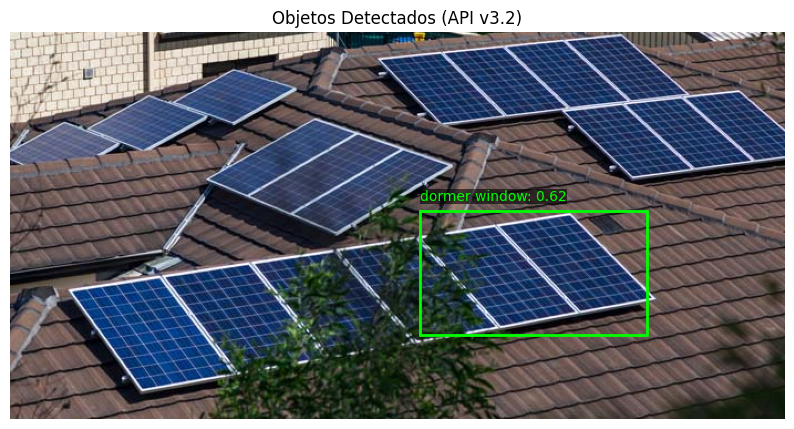

In [52]:
if original_image:
    analysis_results = analyze_image_v32(image_path)

    if analysis_results is not None:
        objects_found = analysis_results['objects']
        tags_found = analysis_results['tags']

        # Mostrar las etiquetas encontradas
        if tags_found:
            print("\n--- Etiquetas Detectadas ---")
            for tag in tags_found:
                print(f"- {tag.get('name', 'N/A')} (Confianza: {tag.get('confidence', 0):.2f})")
        else:
            print("\nNo se detectaron etiquetas.")

        # Mostrar la imagen con los objetos (si se encontraron)
        if objects_found:
             show_objects_on_image(original_image, objects_found)
        else:
             print("\nNo se detectaron objetos.")
             # Mostrar solo la original si no hubo objetos pero sí quizás tags
             plt.figure(figsize=(8, 8))
             plt.imshow(original_image)
             plt.axis('off')
             plt.title("Imagen Original (No se detectaron objetos)")
             plt.show()

    else:
        print("\nNo se pudo obtener el análisis de la API v3.2.")
else:
    print("\nNo se pudo cargar la imagen original.")